# Time Series Challenge -- Kristofer Schobert

Here, we will analyze the time series data titled, "Employment Cost Index: Total compensation for Private industry workers in Professional, scientific, and technical services," found on the Federal Reserve Bank of St. Louis's webpage. The source of this data is the U.S. Bureau of Labor Statistics.

We arrive at some interesting conclusions!

The index of the data is adjusted to have a value of 100 for October of 2005. 

We are given quarterly values for this index (Jan, Apr, Jul, Oct for each year)

https://fred.stlouisfed.org/series/CIU2015400000000I

In [89]:
# importing packages
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA


In [2]:
# importing the data and allowing pandas to interpret the date. 
def parser(x):
    return pd.datetime.strptime(x, '%Y-%m-%d')

series = pd.read_csv('CIU2015400000000I.csv', header = 0, parse_dates=[0], 
                     index_col=0, squeeze=True, date_parser=parser)
series.head()

DATE
2001-01-01    88.2
2001-04-01    88.9
2001-07-01    89.9
2001-10-01    90.3
2002-01-01    90.3
Name: CIU2015400000000I, dtype: float64

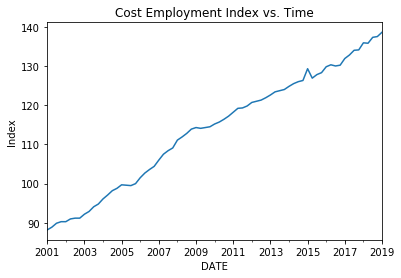

In [17]:
# plotting the time series
series.plot()
plt.title('Cost Employment Index vs. Time')
plt.ylabel('Index')
plt.show()

We see a linear trend in this index. It is thus not stationary, but perhaps it is relatively stationary (i.e. the deferences between neighboring indexes are stationary). 

## Autocorrelation Function

Let's see the autocorrelation plot of our data.

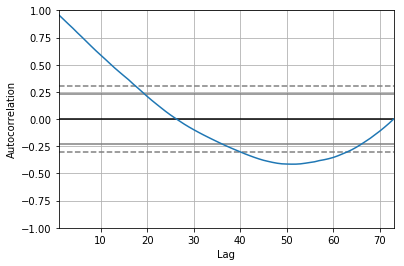

In [4]:
# plotting the auto correlation function for our data
autocorrelation_plot(series)
plt.show()

This is the expected shape of an ACF with a linear time series. It begins very correlated with itself, then the correlation decreases linearly because we lose some datapoints at the end of the sample (they have are not included in the sum of products of points) and because we have a few terms with a negative product in the summation. We then find an equal amount of positive and negated terms in the summation around lag 26. We have our most negative correlation when the lines are shifted far apart, and finally a small negative value when only one pair of points are multiplied together in the summation. Let's take a look at the first difference of our series. 

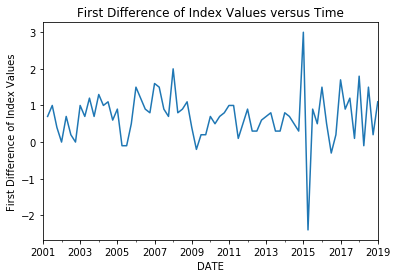

In [21]:
series_df = pd.DataFrame()
series_df['value'] = series
series_df['diff_1'] = series - series.shift()

series_df.plot(y='diff_1', legend=None)
plt.title('First Difference of Index Values versus Time')
plt.ylabel('First Difference of Index Values')
plt.show()

This certainly looks noisy. It seems to have a constant mean as well. This is just speculation though. We will find out if the assumptions are correct when we begin to find a fitting model.

In [151]:
# viewing the dataframe with new column for the first difference values.
series_df.head(8)

,value,diff_1,diff_2
DATE,,,
2001-01-01,88.2,NaN,NaN
2001-04-01,88.9,0.7,NaN
2001-07-01,89.9,1.0,0.3
2001-10-01,90.3,0.4,-0.6
2002-01-01,90.3,0.0,-0.4
2002-04-01,91.0,0.7,0.7
2002-07-01,91.2,0.2,-0.5
2002-10-01,91.2,0.0,-0.2


In [152]:
print('We have {} data points'.format((len(series_df))))

We have 73 data points


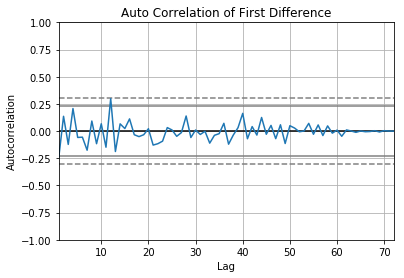

In [7]:
# plotting the auto correlation function for our data
autocorrelation_plot(series_df['diff_1'].iloc[1:])

plt.title('Auto Correlation of First Difference')
plt.show()

The ACF informs us that the first difference of our data is generally not well correlated with itself for any number of lags. It begins to be extremely poorly correlated for lag values greater that 60. The values at lags this large are not informative since we only have 73 data points. 

## Partial Autocorrelation Function

Let's inspect the Partial Autocorrelation Function for our series and its first difference.

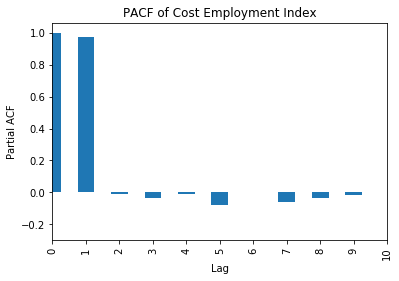

In [144]:
x_acf = pd.DataFrame(pacf(series_df['value']))
x_acf.plot(kind='bar', legend=None)
plt.title("PACF of Cost Employment Index")
plt.xlim((0,10))
plt.ylabel('Partial ACF')
plt.xlabel('Lag')
plt.show()

This PACF plot informs us that when calculating the lag one autocorrelation of our time series, the coefficient beta_1 in 

\begin{align}
\hat{y}_t & = \beta_0 + \beta_1 y_{t-1}\\
\end{align}

is non-zero with a very high statistical significance. Thus an AR(1) looks to be a strong candidate for modeling our time series. We can also see that our time series model does not benifit from a having y_t-2 term or higher. The very low PACF for those lags of two and higher inform us of that. 

It seems very reasonable that the preceding index value plus a fixed value will yield a strong prediction for the current value. Thus I assume our beta_0 value will be of great importance for our predictions.

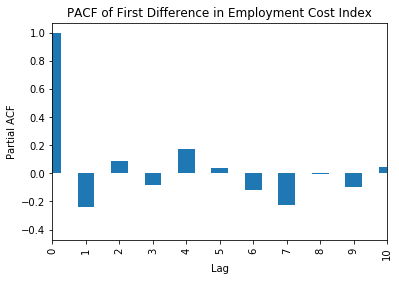

In [143]:
x_acf = pd.DataFrame(pacf(series_df['diff_1'][1:]))
x_acf.plot(kind='bar', legend=None)
plt.xlim((0,10))
plt.title("PACF of First Difference in Employment Cost Index")
plt.ylabel('Partial ACF')
plt.xlabel('Lag')
plt.show()

Perhaps, the preceding first difference value would be somewhat benifitial for predicting current first difference value, but with a lag one PACF magnitude of 0.2, it is should not be very significant. 

## ARIMA Models

Let's generate some ARIMA models and see how they model our data. 

In [95]:

model = ARIMA(series_df['value'], order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                   73
Model:                     ARMA(1, 0)   Log Likelihood                -104.591
Method:                       css-mle   S.D. of innovations              0.970
Date:                Mon, 20 May 2019   AIC                            215.182
Time:                        22:11:12   BIC                            222.054
Sample:                    01-01-2001   HQIC                           217.921
                         - 01-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         113.4107     24.423      4.644      0.000      65.543     161.279
ar.L1.value     0.9992      0.001    922.650      0.000       0.997       1.001
                                    Roots       

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


Here we see that an AR(1) model fits our data very nicely. Our two coefficients (the constant term and the coefficient multiplying the preceding index value) are of high statistical significant. Both coefficient's p-values are essentially 0. Let's see how an AR(2) model performs.

In [100]:
model = ARIMA(series_df['value'], order=(2,0,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                   73
Model:                     ARMA(2, 0)   Log Likelihood                 -98.399
Method:                       css-mle   S.D. of innovations              0.889
Date:                Mon, 20 May 2019   AIC                            204.797
Time:                        22:19:56   BIC                            213.959
Sample:                    01-01-2001   HQIC                           208.449
                         - 01-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         113.5504     24.006      4.730      0.000      66.500     160.601
ar.L1.value     1.3985      0.086     16.258      0.000       1.230       1.567
ar.L2.value    -0.3995      0.086     -4.637    

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


While or PACF analysis hinted that a coefficient multiplying the index value at two preceding time steps was insignificant, this analysis seems to show the opposite. This is due to the linear trend of our series. If one were to fit 


\begin{align}
\hat{y}_t & = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2}\\
\end{align}

our beta_1 and beta_2 term should be roughly equal. The index value two steps away from our current value is just as valuable at predicting our current value as the value one time step away. This can be seen via fitting a linear regression to a linear time series.

In [106]:
# Creating a linear time series with 1000 values

from sklearn import linear_model
regr = linear_model.LinearRegression()
Y = list(range(998))
X = np.array([list(range(1,999)),list(range(2,1000))]).T
regr.fit(X, Y)

# Inspect the results.
print('The Two Coefficients: \n', regr.coef_)


The Two Coefficients: 
 [0.5 0.5]


Here, we have created time series that is exactly linear. We are using y_t-1 and y_t-2 as our features and y_t as our target. The model chooses 0.5 as the coefficient for both parameter in our model. Thus, in the equation

\begin{align}
\hat{y}_t & = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2}\\
\end{align}

beta_1 and beta_2 are both 0.5. We see something very similar in our ARIMA(2,0,0) model. The coefficients are roughly equal. While y_t-2 can be helpful in predicting y_t, it is not necessary. The value of y_t-1 multiplied by a coefficent does a fine job predicting our series and no second coefficient is needed. 

In [112]:
model = ARIMA(series_df['value'], order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   72
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -73.484
Method:                           css   S.D. of innovations              0.671
Date:                Mon, 20 May 2019   AIC                            150.968
Time:                        22:40:47   BIC                            155.521
Sample:                    04-01-2001   HQIC                           152.780
                         - 01-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7000      0.079      8.846      0.000       0.545       0.855
Residuals Description
count    7.200000e+01
mean     1.508221e-09
std      6.761532e-01
min     -3.100000e+00
25%     -4.000000e-01

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi

When taking the first difference, a positive constant (the mean of our differences) is statistically significant. This constant is positive since we have an increasing series. Ultimately, this model is a random walk with a drift. It seems to fit our data well. It also seems intuatively a good choice upon seeing the plot of our time series. That initial plot shows what looks to be a linear trend with noise. Let's see how a moving average model performs when predicting the first difference of our data.

In [113]:
model = ARIMA(series_df['value'], order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   72
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -71.727
Method:                       css-mle   S.D. of innovations              0.655
Date:                Mon, 20 May 2019   AIC                            149.454
Time:                        22:48:11   BIC                            156.284
Sample:                    04-01-2001   HQIC                           152.173
                         - 01-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6990      0.062     11.290      0.000       0.578       0.820
ma.L1.D.value    -0.2009      0.104     -1.931      0.058      -0.405       0.003
                                    Root

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


Well, multiplying the preceding error term by a constant works alright as model for our data. The coefficient we would multiply the preceding error term by is on the cusp of being statistically significant. There is slightly greater than a one in twenty chance that the value for this coefficient is zero. This coefficient is negative which tells us that the value of the next first difference is opposite in sign from the current error. Thus we would expect an alternating difference, and that is what we see in our plot of the first difference of our time series. It is interesting to notice that the first difference is actually not random noise. 

Let's inspect a few other possibilities for modeling our series.

In [133]:
model = ARIMA(series_df['value'], order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   72
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -71.384
Method:                       css-mle   S.D. of innovations              0.652
Date:                Mon, 20 May 2019   AIC                            148.767
Time:                        23:26:13   BIC                            155.597
Sample:                    04-01-2001   HQIC                           151.486
                         - 01-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6989      0.062     11.223      0.000       0.577       0.821
ar.L1.D.value    -0.2370      0.114     -2.082      0.041      -0.460      -0.014
                                    Root

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


We see a similar relation here. It seems that using a preceding first difference is just barely statistically significant in predicting a first difference. This coefficient is negative which informs us that the first differences alternate between a higher and lower value in general. What makes this model conceptually different from the previous model is that this model has a negative coefficient multiplying the previous difference rather than the previous error in the predicted the difference.

Again, we see the alternating trend in the plot of the first differences above. We have an increase in the index followed by a decrease, and this trend holds true in general. This is informative. It gives us more predictive power than the white noise model ARIMA(0,1,0). 

Here, our ARIMA(1,1,0) model is described by the equation

\begin{align}
\Delta \hat{y}_t & = \beta_0 + \beta_1 \Delta y_{t-1} \\
\end{align}

where beta_1 is negative.

Let's take a look at the second difference. If the first difference is generally alternating, maybe there is a deeper trend in the second difference. 

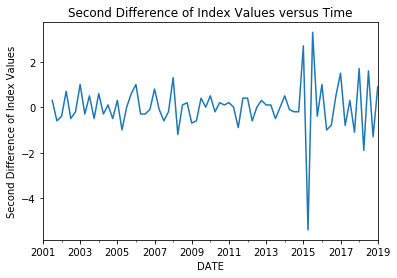

In [128]:
series_df['diff_2'] = series_df['diff_1'] - series_df['diff_1'].shift()
series_df.plot(y='diff_2', legend=None)
plt.title('Second Difference of Index Values versus Time')
plt.ylabel('Second Difference of Index Values')
plt.show()

This again looks to be somewhat alternating. Let's see a potenial model for this. 

In [154]:
model = ARIMA(series_df['value'], order=(5,2,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   71
Model:                 ARIMA(5, 2, 0)   Log Likelihood                 -75.016
Method:                       css-mle   S.D. of innovations              0.689
Date:                Tue, 21 May 2019   AIC                            164.031
Time:                        00:51:39   BIC                            179.870
Sample:                    07-01-2001   HQIC                           170.330
                         - 01-01-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0024      0.022      0.108      0.914      -0.042       0.046
ar.L1.D2.value    -1.0391      0.118     -8.781      0.000      -1.271      -0.807
ar.L2.D2.value    -0.7749      0.170

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


This is very interesting. The first three coefficients are very much statistically significant, and they are all negative. Knowing the three preceding second differences is extremely valuable in predicting the current second difference. I would have never known this by just looking at the data. Also, our constant is zero because the second difference is on average zero. Let's look at a PACF for the second difference. 

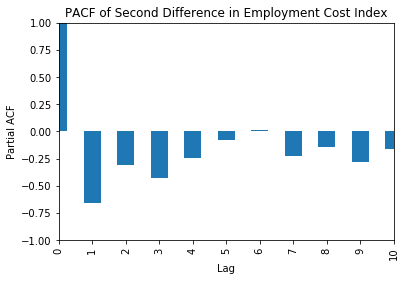

In [147]:
x_acf = pd.DataFrame(pacf(series_df['diff_2'][2:]))
x_acf.plot(kind='bar', legend=None)
plt.xlim((0, 10))
plt.ylim((-1,1))
plt.title("PACF of Second Difference in Employment Cost Index")
plt.ylabel('Partial ACF')
plt.xlabel('Lag')
plt.show()

Here we see that, yes, the first three coefficients are significant given this PACF plot. We see this because the partial autocorrelation function has a magnitude of more than a quarter for the first three lags. The fourth coefficient is potentially valuable, but during our model fitting we saw that that coefficient has a p-value larger than 0.5, thus we will not include it in our model. 

# Conclusion

Our final model for our data is ARIMA(3,2,0):

\begin{align}
\Delta\Delta \hat{y}_t & = \beta_1 \Delta\Delta y_{t-1} + \beta_2 \Delta\Delta y_{t-2} + \beta_3 \Delta\Delta y_{t-3}\\
\end{align}

where each coefficient is negative.

This is very exciting, and I did not see this coming. At first, I was under the impression that we just had a linear trend with some added noise. It turns out that that "noise" was a pattern! The first difference alternates from one time step to the next, and the second difference is an AR(3) model. 

The first difference is alternating. What does this mean for our series. Well, we have one index value per quarter - one in January, April, July, and October. Thus, this employment cost index is approximately seasonal. Perhaps, the difference in the index is higher from January to April and July to October, but lower from April to July and October to January. We can approximate this with the seasons. During two nonadjacent season (i.e summer and winter) we have a increase in the difference in the index and during the other two seasons: a decrease in the difference in the index. 

The second difference has even more curious behavior. With all three coefficients being negative we don't have such a simple alternating behavior. This model has three features that all come into play. We are describing the second difference. This is the difference of the difference in the index. If the index increased some from January to April, but then increaed even more from April to July, we would have a positive second difference. Thus, the difference in the difference between Apr to July and July to Oct is related to the difference in the differnce between Jan to Apr and Apr to July, and Oct(previous year) to Jan and Jan to Apr, and July(previous year) to Oct and Oct to Jan. Wow! Almost a whole year cycle. The current difference in the difference is significantly dependent on the three most recent differences of differences. This Employment Cost Index is depended on the accelerations of the index during the three past quarters. 

Could it be dependent on even more differences? Potentially. The software we have used does not allow for differences greater than two. It would be very interesting if the third difference is helpful for predictions. 

Well, we now know this is certainly not noise. We have found striking patterns in the first and second differences of the Employment Cost Index: a measure of the total compensation for private industry workers in professional, scientific, and technical services!

This could be potentially useful information for both the employers and employees of these industries. They could have a better grasp on the job market by knowing this information. They could be saving money, time, and energy by understanding the ebbs and flows of this index. 